In [1]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [2]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

from langgraph.graph import StateGraph 
from langgraph.graph import START, END

from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool

from langchain_teddynote.tools.tavily import TavilySearch
from langchain_teddynote.tools import GoogleNews

from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.messages import display_message_tree
from langchain_teddynote.messages import pretty_print_messages
from langchain_core.runnables import RunnableConfig

from langchain_openai import ChatOpenAI

In [3]:
######### 1. 상태 정의 #########

# 상태 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [4]:
######### 2. 도구 정의 및 바인딩 #########

tool = TavilySearch(max_results=1)

tools = [tool]

In [5]:
######### 3. LLM을 도구와 결합 #########

llm = ChatOpenAI(
    api_key=key, 
    model_name='gpt-4o-mini',
    temperature=0.1
)

llm_with_tools = llm.bind_tools(tools)

In [7]:
def chatbot(state: State):
    answer = llm_with_tools.invoke(state['messages'])

    print('=================================================================================')
    print(f'chatbot() 실행\n')
    print(f"[1] state[messages]: \n{state['messages']}\n")
    # print(f'[2] chatbot answer: \n', answer , "\n")
    print(f'[2] chatbot answer: \n', answer.content)
    print(f'[3] answer.additional_kwargs: \n', answer.additional_kwargs)
    print('=================================================================================')

    return {'messages': [answer]}

In [8]:
graph_builder = StateGraph(State)

In [9]:
# chatbot 노드 추가
graph_builder.add_node('chatbot', chatbot)

In [10]:
# 도구 노드 생성
tool_node = ToolNode(tools=tools)

In [11]:
# 도구 노드 추가
graph_builder.add_node('tools', tool_node)

In [12]:
graph_builder.add_conditional_edges(
    'chatbot',
    tools_condition
)

In [13]:
######### 5. 엣지 추가 #########

# tools 에서 chatbot 으로
graph_builder.add_edge('tools', 'chatbot')

In [14]:
# START 에서 chatbot 으로
graph_builder.add_edge(START, 'chatbot')

In [15]:
# chatbot 에서 END 로
graph_builder.add_edge('chatbot', END)

In [16]:
######### 6. 메모리 생성 #######

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [17]:
######### 7. 그래프 컴파일 #######

graph = graph_builder.compile(checkpointer=memory)

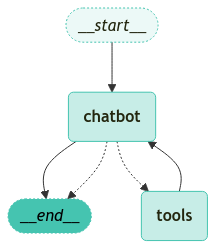

In [18]:
######### 8. 그래프 #######

visualize_graph(graph)

In [85]:
from langchain_teddynote.graphs import generate_random_hash

thread_id = generate_random_hash()
print(f"thread_id: {thread_id}")

question = "대구 중앙떡볶이에 대해서 알려주세요"

input = State(messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,             
    configurable={"thread_id": thread_id},  
    tags=["data-tag"],                  
)

thread_id: e5747b


In [82]:
list(graph.channels)

['messages',
 '__start__',
 'chatbot',
 'tools',
 'branch:__start__:__self__:chatbot',
 'branch:__start__:__self__:tools',
 'branch:chatbot:__self__:chatbot',
 'branch:chatbot:__self__:tools',
 'branch:tools:__self__:chatbot',
 'branch:tools:__self__:tools',
 'start:chatbot',
 'branch:chatbot:tools_condition:tools']

In [83]:
from langchain.schema import HumanMessage, AIMessage
from langchain_core.messages import ToolMessage

In [86]:
i = 1

for event in graph.stream(input=input, config=config,  interrupt_before=["tools"], stream_mode="values"):
    print(f'({i})')
    print('=== 반복문 바같 === 시작')

    for key, value in event.items():
        print('=== 반복문 === 시작')
        print(f'\n[노드 이름]: {key}')                    # key 에는 노드의 이름
                    

        if key =='messages':
            print(f"\n해당 노드의 값[value]: \n{value}")
            
            if isinstance(value[-1], HumanMessage):
                print('==================== HumanMessage ========================')
                print(f"해당 노드의 값 [value][-1]: \n{value[-1]}")                     # value에는 해당 노드의 값. state 이다
                print('==================== END HumanMessage ====================')
                print() 
            elif isinstance(value[-1], AIMessage):
                print('==================== AIMessage ========================')
                print(f"해당 노드의 값 [value][-1]: \n{value[-1]}")        
                print('==================== END AIMessage ====================')     
                print()   
            elif isinstance(value[-1], ToolMessage):
                print('==================== ToolMessage ========================')
                print(f"해당 노드의 값 [value][-1]: \n{value[-1]}")   
                print('==================== END ToolMessage ====================')     
                print()                   

        print('=== 반복문 === 끝')
    print('=== 반복문 바같 === 끝\n\n')
    
    i=i+1

(1)
=== 반복문 바같 === 시작
=== 반복문 === 시작

[노드 이름]: messages

해당 노드의 값[value]: 
[HumanMessage(content='대구 중앙떡볶이에 대해서 알려주세요', additional_kwargs={}, response_metadata={}, id='0edea2a1-35d3-4b1e-8146-4e370e43582f')]
==================== HumanMessage ========================
해당 노드의 값 [value][-1]: 
content='대구 중앙떡볶이에 대해서 알려주세요' additional_kwargs={} response_metadata={} id='0edea2a1-35d3-4b1e-8146-4e370e43582f'
==================== END HumanMessage ====================

=== 반복문 === 끝
=== 반복문 바같 === 끝


chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='대구 중앙떡볶이에 대해서 알려주세요', additional_kwargs={}, response_metadata={}, id='0edea2a1-35d3-4b1e-8146-4e370e43582f')]

[2] chatbot answer: 
 
[3] answer.additional_kwargs: 
 {'tool_calls': [{'id': 'call_dQjXjdxigJ3YFrAx1IcnvFPr', 'function': {'arguments': '{"query":"대구 중앙떡볶이"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}
(2)
=== 반복문 바같 === 시작
=== 반복문 === 시작

[노드 이름]: messages

해당 노드의 값[value]: 
[HumanMessage(content='대구 중앙

In [87]:
thread_id = generate_random_hash()
print(f"thread_id: {thread_id}")

question = "대구 중앙떡볶이에 대해서 알려주세요"

input = State(messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,             
    configurable={"thread_id": thread_id},  
    tags=["data-tag"],                  
)

thread_id: d95677


In [88]:
events = graph.stream(
    input=input, config=config, interrupt_before=["tools"], stream_mode="values"
)

for event in events:
    print('[event] 전체')
    print(event)
    print()

    if "messages" in event:                     # 메시지가 이벤트에 포함된 경우        
        event["messages"][-1].pretty_print()    # 마지막 메시지의 예쁜 출력

[event] 전체
{'messages': [HumanMessage(content='대구 중앙떡볶이에 대해서 알려주세요', additional_kwargs={}, response_metadata={}, id='7b99a35b-6bfa-46cb-a096-c7c2abadb0b8')]}

================================ Human Message =================================

대구 중앙떡볶이에 대해서 알려주세요
chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='대구 중앙떡볶이에 대해서 알려주세요', additional_kwargs={}, response_metadata={}, id='7b99a35b-6bfa-46cb-a096-c7c2abadb0b8')]

[2] chatbot answer: 
 
[3] answer.additional_kwargs: 
 {'tool_calls': [{'id': 'call_RMv6aTOfOFdKqSvH668R97c6', 'function': {'arguments': '{"query":"대구 중앙떡볶이"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}
[event] 전체
{'messages': [HumanMessage(content='대구 중앙떡볶이에 대해서 알려주세요', additional_kwargs={}, response_metadata={}, id='7b99a35b-6bfa-46cb-a096-c7c2abadb0b8'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_RMv6aTOfOFdKqSvH668R97c6', 'function': {'arguments': '{"query":"대구 중앙떡볶이"}', 'name': 'tavily_web_search'}, 'type'

In [86]:
snapshot = graph.get_state(config)      # 그래프 상태 스냅샷 생성

In [87]:
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='랭그래프에 대해서 알려주세요', additional_kwargs={}, response_metadata={}, id='650f8672-cf12-47b1-9a45-d14c1e9b1506'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AchZFyIxtWR1bizEddlvvNtK', 'function': {'arguments': '{"query":"랭그래프"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 99, 'total_tokens': 120, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_709714d124', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-11e89087-c05e-477d-a816-a72b188ebe08-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '랭그래프'}, 'id': 'call_AchZFyIxtWR1bizEddlvvNtK', 'type': 'tool_call'}], usage_me

In [88]:
snapshot.values['messages']

[HumanMessage(content='랭그래프에 대해서 알려주세요', additional_kwargs={}, response_metadata={}, id='650f8672-cf12-47b1-9a45-d14c1e9b1506'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AchZFyIxtWR1bizEddlvvNtK', 'function': {'arguments': '{"query":"랭그래프"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 99, 'total_tokens': 120, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_709714d124', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-11e89087-c05e-477d-a816-a72b188ebe08-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '랭그래프'}, 'id': 'call_AchZFyIxtWR1bizEddlvvNtK', 'type': 'tool_call'}], usage_metadata={'input_tokens': 99, 'outp

In [89]:
last_message = snapshot.values["messages"][-1]      # 가장 최근 메시지 추출

In [90]:
last_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AchZFyIxtWR1bizEddlvvNtK', 'function': {'arguments': '{"query":"랭그래프"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 99, 'total_tokens': 120, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_709714d124', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-11e89087-c05e-477d-a816-a72b188ebe08-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '랭그래프'}, 'id': 'call_AchZFyIxtWR1bizEddlvvNtK', 'type': 'tool_call'}], usage_metadata={'input_tokens': 99, 'output_tokens': 21, 'total_tokens': 120, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'r

In [91]:
last_message.content

''

In [92]:
last_message.additional_kwargs

{'tool_calls': [{'id': 'call_AchZFyIxtWR1bizEddlvvNtK',
   'function': {'arguments': '{"query":"랭그래프"}', 'name': 'tavily_web_search'},
   'type': 'function'}],
 'refusal': None}

In [93]:
last_message.additional_kwargs['tool_calls']

[{'id': 'call_AchZFyIxtWR1bizEddlvvNtK',
  'function': {'arguments': '{"query":"랭그래프"}', 'name': 'tavily_web_search'},
  'type': 'function'}]

In [94]:
last_message.additional_kwargs['tool_calls'][0]

{'id': 'call_AchZFyIxtWR1bizEddlvvNtK',
 'function': {'arguments': '{"query":"랭그래프"}', 'name': 'tavily_web_search'},
 'type': 'function'}

In [95]:
last_message.additional_kwargs['tool_calls'][0]['id']

'call_AchZFyIxtWR1bizEddlvvNtK'

In [96]:
last_message.additional_kwargs['tool_calls'][0]['function']

{'arguments': '{"query":"랭그래프"}', 'name': 'tavily_web_search'}

In [97]:
last_message.additional_kwargs['tool_calls'][0]['function']['arguments']

'{"query":"랭그래프"}'

In [98]:
last_message.additional_kwargs['tool_calls'][0]['function']['name']

'tavily_web_search'

In [99]:
last_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_AchZFyIxtWR1bizEddlvvNtK)
 Call ID: call_AchZFyIxtWR1bizEddlvvNtK
  Args:
    query: 랭그래프


In [100]:
modified_search_result = """[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/)을 참고하세요."""

In [101]:
# 수정하고자 하는 ToolMessage 의 tool_call_id 추출
tool_call_id = last_message.tool_calls[0]["id"]
tool_call_id

'call_AchZFyIxtWR1bizEddlvvNtK'

In [102]:
from langchain_core.messages import AIMessage, ToolMessage

new_messages = [                            # LLM API의 도구 호출과 일치하는 ToolMessage가 필요합니다
    
    ToolMessage(                                
        content=modified_search_result,     # 수정된 웹 검색 결과
        tool_call_id=tool_call_id,          # 수정하고자 하는 ToolMessage 의 tool_call_id
    ),
    # LLM의 응답에 직접적으로 내용 추가
    # AIMessage(content=modified_search_result),
]

In [103]:
new_messages[-1]

ToolMessage(content='[수정된 웹 검색 결과] \nLangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.\nLangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.\n\n자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/)을 참고하세요.', tool_call_id='call_AchZFyIxtWR1bizEddlvvNtK')

In [104]:
new_messages[-1].pretty_print()

================================= Tool Message =================================

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/)을 참고하세요.


In [105]:
graph.update_state(
    config,                         # 업데이트할 상태 지정    
    {"messages": new_messages},     # 제공할 업데이트된 값. State의 메시지는 "추가 전용"으로 기존 상태에 추가됨
    as_node="tools",                # 어떤 노드로 부터 나온 상태 값을 업데이터 할 것인가 지정
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff32dd-809d-657e-8002-eb8f425fb594'}}

In [106]:
print("(최근 1개의 메시지 출력)\n")
print(graph.get_state(config).values["messages"][-1])

(최근 1개의 메시지 출력)

content='[수정된 웹 검색 결과] \nLangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.\nLangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.\n\n자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/)을 참고하세요.' id='431df0dc-41e0-435f-a745-2f6903c52cc6' tool_call_id='call_AchZFyIxtWR1bizEddlvvNtK'


In [107]:
graph.get_state(config).values["messages"]       # 전체 메시지

[HumanMessage(content='랭그래프에 대해서 알려주세요', additional_kwargs={}, response_metadata={}, id='650f8672-cf12-47b1-9a45-d14c1e9b1506'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AchZFyIxtWR1bizEddlvvNtK', 'function': {'arguments': '{"query":"랭그래프"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 99, 'total_tokens': 120, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_709714d124', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-11e89087-c05e-477d-a816-a72b188ebe08-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '랭그래프'}, 'id': 'call_AchZFyIxtWR1bizEddlvvNtK', 'type': 'tool_call'}], usage_metadata={'input_tokens': 99, 'outp

In [108]:
snapshot = graph.get_state(config)

In [109]:
print(snapshot.next)

('chatbot',)


In [110]:
events = graph.stream(None, config, stream_mode="values")

# 이벤트 반복 처리
for event in events:
    print('[event] 전체')
    print(event)
    print()

    if "messages" in event:                         # 메시지가 이벤트에 포함된 경우        
        event["messages"][-1].pretty_print()        # 마지막 메시지의 예쁜 출력

[event] 전체
{'messages': [HumanMessage(content='랭그래프에 대해서 알려주세요', additional_kwargs={}, response_metadata={}, id='650f8672-cf12-47b1-9a45-d14c1e9b1506'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AchZFyIxtWR1bizEddlvvNtK', 'function': {'arguments': '{"query":"랭그래프"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 99, 'total_tokens': 120, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_709714d124', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-11e89087-c05e-477d-a816-a72b188ebe08-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '랭그래프'}, 'id': 'call_AchZFyIxtWR1bizEddlvvNtK', 'type': 'tool_call'}], usage_metadata={'i

chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='랭그래프에 대해서 알려주세요', additional_kwargs={}, response_metadata={}, id='650f8672-cf12-47b1-9a45-d14c1e9b1506'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AchZFyIxtWR1bizEddlvvNtK', 'function': {'arguments': '{"query":"랭그래프"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 99, 'total_tokens': 120, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_709714d124', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-11e89087-c05e-477d-a816-a72b188ebe08-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '랭그래프'}, 'id': 'call_AchZFyIxtWR1bizEddlvvNtK', 'type': 'tool_call'}], usage_

In [111]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 최근 세 개의 메시지 출력
for message in snapshot.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

랭그래프에 대해서 알려주세요
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_AchZFyIxtWR1bizEddlvvNtK)
 Call ID: call_AchZFyIxtWR1bizEddlvvNtK
  Args:
    query: 랭그래프
================================= Tool Message =================================

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/)을 참고하세요.
================================== Ai Message ==================================

랭그래프(LangGraph)는 상태 기반의 다중 액터 애플리케이션을 구축할 수 있도록 지원하는 오픈 소스 라이브러리입니다. 이 라이브러리는 LLM(대형 언어 모델)을 활용하여 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능 등을 제공합니다.

더 자세한 정보와 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/)을 참고하시면 좋습니다.


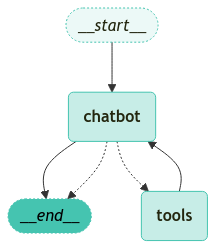

In [112]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [113]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 최근 세 개의 메시지 출력
for message in snapshot.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

랭그래프에 대해서 알려주세요
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_AchZFyIxtWR1bizEddlvvNtK)
 Call ID: call_AchZFyIxtWR1bizEddlvvNtK
  Args:
    query: 랭그래프
================================= Tool Message =================================

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/)을 참고하세요.
================================== Ai Message ==================================

랭그래프(LangGraph)는 상태 기반의 다중 액터 애플리케이션을 구축할 수 있도록 지원하는 오픈 소스 라이브러리입니다. 이 라이브러리는 LLM(대형 언어 모델)을 활용하여 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능 등을 제공합니다.

더 자세한 정보와 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/)을 참고하시면 좋습니다.


In [117]:
from langchain_teddynote.graphs import generate_random_hash

thread_id = generate_random_hash()
print(f"thread_id: {thread_id}")

thread_id: cba738


In [118]:
question = "파이썬에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!"

input = State(messages=[("user", question)])            
config = {"configurable": {"thread_id": thread_id}}     # 새로운 config 생성

events = graph.stream(
    input=input,
    config=config,
    interrupt_before=["tools"],
    stream_mode="values")

for event in events:
    print('[event] 전체')
    print(event)
    print()
    
    if "messages" in event:
        event["messages"][-1].pretty_print()

[event] 전체
{'messages': [HumanMessage(content='파이썬에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!', additional_kwargs={}, response_metadata={}, id='2755733d-a3e4-4d18-b693-2197f1a19ad3')]}

================================ Human Message =================================

파이썬에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!
chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='파이썬에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!', additional_kwargs={}, response_metadata={}, id='2755733d-a3e4-4d18-b693-2197f1a19ad3')]

[2] chatbot answer: 
 
[3] answer.additional_kwargs: 
 {'tool_calls': [{'id': 'call_DZt4GA0ZcEb8tcZZLNQ9Il3n', 'function': {'arguments': '{"query":"파이썬 학습 자료 추천"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}
[event] 전체
{'messages': [HumanMessage(content='파이썬에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!', additional_kwargs={}, response_metadata={}, id='2755733d-a3e4-4d18-b693-2197f1a19ad3'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DZt4GA0ZcEb8tcZZLNQ9Il3n', 'function': {'

In [119]:
# config 를 복사
config_copy = config.copy()

In [120]:
config_copy

{'configurable': {'thread_id': 'cba738'}}

In [129]:
from langchain_core.messages import AIMessage

# 스냅샷 상태 가져오기
snapshot = graph.get_state(config)

# messages 의 마지막 메시지 가져오기
existing_message = snapshot.values["messages"][-1]

print('existing_message 전체:', existing_message)
print()

# 메시지 ID 출력
print("Message ID", existing_message.id)
print()

print('existing_message.tool_calls:', existing_message.tool_calls)

existing_message 전체: content='' additional_kwargs={'tool_calls': [{'id': 'call_DZt4GA0ZcEb8tcZZLNQ9Il3n', 'function': {'arguments': '{"query":"파이썬 학습 자료 추천"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 112, 'total_tokens': 137, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_709714d124', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-4dbf3c4f-7e92-4e24-9075-4388d7c91a26-0' tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '파이썬 학습 자료 추천'}, 'id': 'call_DZt4GA0ZcEb8tcZZLNQ9Il3n', 'type': 'tool_call'}] usage_metadata={'input_tokens': 112, 'output_tokens': 25, 'total_tokens': 137, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_d

In [124]:
# 첫 번째 도구 호출 출력
print(existing_message.tool_calls[0])

{'name': 'tavily_web_search', 'args': {'query': '파이썬 학습 자료 추천'}, 'id': 'call_DZt4GA0ZcEb8tcZZLNQ9Il3n', 'type': 'tool_call'}


In [130]:
# tool_calls 를 복사하여 새로운 도구 호출 생성
new_tool_call = existing_message.tool_calls[0].copy()

In [131]:
# 쿼리 매개변수 업데이트(갱신)
new_tool_call["args"] = {"query": "python 학습자료:www.naver.com"}
new_tool_call

{'name': 'tavily_web_search',
 'args': {'query': 'python 학습자료:www.naver.com'},
 'id': 'call_DZt4GA0ZcEb8tcZZLNQ9Il3n',
 'type': 'tool_call'}

In [132]:
new_message = AIMessage(                    # AIMessage 생성
    content=existing_message.content,
    tool_calls=[new_tool_call],    
    id=existing_message.id,                 # 중요! ID는 메시지를 상태에 추가하는 대신 교체하는 방법
)

print(new_message.id)

run-4dbf3c4f-7e92-4e24-9075-4388d7c91a26-0


In [133]:
# 수정한 메시지 출력
new_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_DZt4GA0ZcEb8tcZZLNQ9Il3n)
 Call ID: call_DZt4GA0ZcEb8tcZZLNQ9Il3n
  Args:
    query: python 학습자료:www.naver.com


In [134]:
# 업데이트된 도구 호출 출력
print(new_message.tool_calls[0])

{'name': 'tavily_web_search', 'args': {'query': 'python 학습자료:www.naver.com'}, 'id': 'call_DZt4GA0ZcEb8tcZZLNQ9Il3n', 'type': 'tool_call'}


In [135]:
# 메시지 ID 출력
print("\nMessage ID", new_message.id)


Message ID run-4dbf3c4f-7e92-4e24-9075-4388d7c91a26-0


In [136]:
# 상태 업데이트
graph.update_state(config, {"messages": [new_message]})

{'configurable': {'thread_id': 'cba738',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff3302-4792-60aa-8002-f229422cd608'}}

In [137]:
# 마지막 메시지의 도구 호출 가져오기
graph.get_state(config).values["messages"][-1].tool_calls

[{'name': 'tavily_web_search',
  'args': {'query': 'python 학습자료:www.naver.com'},
  'id': 'call_DZt4GA0ZcEb8tcZZLNQ9Il3n',
  'type': 'tool_call'}]

In [138]:
# 그래프 스트림에서 이벤트 수신
events = graph.stream(None, config, stream_mode="values")

# 각 이벤트에 대한 처리
for event in events:
    print('[event] 전체')
    print(event)
    print()

    if "messages" in event:                         # 메시지가 있는 경우 마지막 메시지 출력
        event["messages"][-1].pretty_print()

[event] 전체
{'messages': [HumanMessage(content='파이썬에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!', additional_kwargs={}, response_metadata={}, id='2755733d-a3e4-4d18-b693-2197f1a19ad3'), AIMessage(content='', additional_kwargs={}, response_metadata={}, id='run-4dbf3c4f-7e92-4e24-9075-4388d7c91a26-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': 'python 학습자료:www.naver.com'}, 'id': 'call_DZt4GA0ZcEb8tcZZLNQ9Il3n', 'type': 'tool_call'}])]}

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_DZt4GA0ZcEb8tcZZLNQ9Il3n)
 Call ID: call_DZt4GA0ZcEb8tcZZLNQ9Il3n
  Args:
    query: python 학습자료:www.naver.com
[event] 전체
{'messages': [HumanMessage(content='파이썬에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!', additional_kwargs={}, response_metadata={}, id='2755733d-a3e4-4d18-b693-2197f1a19ad3'), AIMessage(content='', additional_kwargs={}, response_metadata={}, id='run-4dbf3c4f-7e92-4e24-9075-4388d7c91a26-0', tool_calls=[{'name': 'tavily_web_sear

In [139]:
# 이벤트 스트림 생성
events = graph.stream(
    {
        "messages": (
            "user",
            "내가 지금까지 배운 내용에 대해서 매우 친절하고 정성스럽게 한국어로 답변해줘! 출처를 반드시 포함해줘!",
        )
    },
    config,
    stream_mode="values",
)

# 메시지 이벤트 처리
for event in events:
    print('[event] 전체')
    print(event)
    print()
    
    if "messages" in event:
        event["messages"][-1].pretty_print()

[event] 전체
{'messages': [HumanMessage(content='파이썬에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!', additional_kwargs={}, response_metadata={}, id='2755733d-a3e4-4d18-b693-2197f1a19ad3'), AIMessage(content='', additional_kwargs={}, response_metadata={}, id='run-4dbf3c4f-7e92-4e24-9075-4388d7c91a26-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': 'python 학습자료:www.naver.com'}, 'id': 'call_DZt4GA0ZcEb8tcZZLNQ9Il3n', 'type': 'tool_call'}]), ToolMessage(content='[{"title": "(Python) 파이썬 자습서 _ 파이썬 언어를 배우기 좋은 학습 자료 제공 : 네이버 블로그", "url": "https://blog.naver.com/PostView.naver?blogId=nabilera1&logNo=223695637384", "content": "The same site also contains distributions of and pointers to many free third party Python modules, programs and tools, and additional documentation. 파이썬 인터프리터는 C 나 C++ (또는 C에서 호출 가능한 다른 언어들)로 구현된 새 함수나 자료 구조를 쉽게 추가할 수 있습니다.", "score": 0.7738498, "raw_content": null}]', name='tavily_web_search', id='4faeacbb-3bff-4054-a42d-bdb120d1c562', tool_call_id='call_DZt4GA0ZcEb8tcZZ

In [140]:
graph.get_state(config).values["messages"][-1].pretty_print()

================================== Ai Message ==================================

물론입니다! 지금까지 배운 내용을 정리해드리겠습니다.

1. **파이썬의 기본 개념**: 파이썬은 간결하고 읽기 쉬운 문법을 가진 프로그래밍 언어로, 초보자에게 적합합니다. 변수, 데이터 타입, 조건문, 반복문 등의 기본 개념을 익히는 것이 중요합니다.

2. **함수와 모듈**: 파이썬에서는 함수를 정의하여 코드의 재사용성을 높일 수 있습니다. 또한, 다양한 모듈을 활용하여 기능을 확장할 수 있습니다.

3. **자료구조**: 리스트, 튜플, 딕셔너리, 집합 등의 자료구조를 이해하고 활용하는 것이 중요합니다. 이를 통해 데이터를 효율적으로 관리할 수 있습니다.

4. **객체지향 프로그래밍**: 파이썬은 객체지향 프로그래밍(OOP)을 지원합니다. 클래스와 객체의 개념을 이해하고, 이를 활용하여 코드를 구조화할 수 있습니다.

5. **라이브러리와 프레임워크**: 파이썬은 다양한 라이브러리와 프레임워크를 제공합니다. 예를 들어, 데이터 분석을 위한 Pandas, 웹 개발을 위한 Django 등이 있습니다.

이러한 내용을 바탕으로 파이썬을 더욱 깊이 있게 학습하실 수 있습니다. 추가적인 자료나 질문이 필요하시면 언제든지 말씀해 주세요!

출처: [파이썬 자습서 - 네이버 블로그](https://blog.naver.com/PostView.naver?blogId=nabilera1&logNo=223695637384)


In [141]:
to_replay_state = None

# 상태 기록 가져오기
for state in graph.get_state_history(config):

    messages = state.values["messages"]

    if len(messages) > 0:
        print(state.values["messages"][-1].id)
        # 메시지 수 및 다음 상태 출력
        print("메시지 수: ", len(state.values["messages"]), "다음 노드: ", state.next)
        print("-" * 80)
        # 특정 상태 선택 기준: 채팅 메시지 수
        if len(state.values["messages"]) == 2:
            # 특정 메시지 ID 선택
            to_replay_state = state

run-b37c0bfb-4426-4765-be57-4b921861d689-0
메시지 수:  6 다음 노드:  ()
--------------------------------------------------------------------------------
8b147c87-208f-4950-bea9-6c6c0c353783
메시지 수:  5 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
run-632bbd3d-3715-4f42-b3ca-4d524503b202-0
메시지 수:  4 다음 노드:  ('__start__',)
--------------------------------------------------------------------------------
run-632bbd3d-3715-4f42-b3ca-4d524503b202-0
메시지 수:  4 다음 노드:  ()
--------------------------------------------------------------------------------
4faeacbb-3bff-4054-a42d-bdb120d1c562
메시지 수:  3 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
run-4dbf3c4f-7e92-4e24-9075-4388d7c91a26-0
메시지 수:  2 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
run-4dbf3c4f-7e92-4e24-9075-4388d7c91a26-0
메시지 수:  2 다음 노드:  ('tools',)
------------------------------

In [142]:
to_replay_state

StateSnapshot(values={'messages': [HumanMessage(content='파이썬에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!', additional_kwargs={}, response_metadata={}, id='2755733d-a3e4-4d18-b693-2197f1a19ad3'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DZt4GA0ZcEb8tcZZLNQ9Il3n', 'function': {'arguments': '{"query":"파이썬 학습 자료 추천"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 112, 'total_tokens': 137, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_709714d124', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4dbf3c4f-7e92-4e24-9075-4388d7c91a26-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '파이썬 학습 자료 추천'}, 'id': 'call_DZt4GA0ZcEb8tcZZLNQ9

In [146]:
from langchain_teddynote.messages import display_message_tree

# 선택한 메시지 가져오기
existing_message = to_replay_state.values["messages"][-1]
print(existing_message)
print()

# 메시지 트리 출력
display_message_tree(existing_message)

content='' additional_kwargs={'tool_calls': [{'id': 'call_DZt4GA0ZcEb8tcZZLNQ9Il3n', 'function': {'arguments': '{"query":"파이썬 학습 자료 추천"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 112, 'total_tokens': 137, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_709714d124', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-4dbf3c4f-7e92-4e24-9075-4388d7c91a26-0' tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '파이썬 학습 자료 추천'}, 'id': 'call_DZt4GA0ZcEb8tcZZLNQ9Il3n', 'type': 'tool_call'}] usage_metadata={'input_tokens': 112, 'output_tokens': 25, 'total_tokens': 137, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0,

In [147]:
tool_call = existing_message.tool_calls[0].copy()
tool_call["args"] = {"query": "LangGraph human-in-the-loop workflow site:reddit.com"}
tool_call

{'name': 'tavily_web_search',
 'args': {'query': 'LangGraph human-in-the-loop workflow site:reddit.com'},
 'id': 'call_DZt4GA0ZcEb8tcZZLNQ9Il3n',
 'type': 'tool_call'}

In [149]:
new_message = AIMessage(                    # AIMessage 생성
    content=existing_message.content,
    tool_calls=[tool_call],    
    id=existing_message.id,                 # 중요! ID는 메시지를 상태에 추가하는 대신 교체하는 방법
)

# 수정한 메시지 출력
new_message.tool_calls[0]["args"]

{'query': 'LangGraph human-in-the-loop workflow site:reddit.com'}

In [150]:
# 업데이트 전 메시지 확인
graph.get_state(to_replay_state.config).values["messages"][-1].tool_calls

[{'name': 'tavily_web_search',
  'args': {'query': '파이썬 학습 자료 추천'},
  'id': 'call_DZt4GA0ZcEb8tcZZLNQ9Il3n',
  'type': 'tool_call'}]

In [151]:
# 상태 업데이트
updated_state = graph.update_state(
    to_replay_state.config,
    {"messages": [new_message]},
)

updated_state

{'configurable': {'thread_id': 'cba738',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff3318-306a-6c03-8002-ed5fddedd1b2'}}

In [152]:
# config 에는 updated_state 를 전달합니다. 이는 임의로 갱신한 상태를 전달하는 것입니다.
for event in graph.stream(None, updated_state, stream_mode="values"):
    
    print('[event] 전체')
    print(event)
    print()
    
    if "messages" in event:                         # 메시지가 이벤트에 포함된 경우
        event["messages"][-1].pretty_print()        # 마지막 메시지 출력

[event] 전체
{'messages': [HumanMessage(content='파이썬에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!', additional_kwargs={}, response_metadata={}, id='2755733d-a3e4-4d18-b693-2197f1a19ad3'), AIMessage(content='', additional_kwargs={}, response_metadata={}, id='run-4dbf3c4f-7e92-4e24-9075-4388d7c91a26-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': 'LangGraph human-in-the-loop workflow site:reddit.com'}, 'id': 'call_DZt4GA0ZcEb8tcZZLNQ9Il3n', 'type': 'tool_call'}])]}

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_DZt4GA0ZcEb8tcZZLNQ9Il3n)
 Call ID: call_DZt4GA0ZcEb8tcZZLNQ9Il3n
  Args:
    query: LangGraph human-in-the-loop workflow site:reddit.com
[event] 전체
{'messages': [HumanMessage(content='파이썬에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!', additional_kwargs={}, response_metadata={}, id='2755733d-a3e4-4d18-b693-2197f1a19ad3'), AIMessage(content='', additional_kwargs={}, response_metadata={}, id='run-4dbf3c4f-7e92-4e24-9075-

In [153]:
# 최종 결과 출력
for msg in graph.get_state(config).values["messages"]:
    msg.pretty_print()

================================ Human Message =================================

파이썬에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_DZt4GA0ZcEb8tcZZLNQ9Il3n)
 Call ID: call_DZt4GA0ZcEb8tcZZLNQ9Il3n
  Args:
    query: LangGraph human-in-the-loop workflow site:reddit.com
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "Human intervention in agent workflows : r/LangChain - Reddit", "url": "https://www.reddit.com/r/LangChain/comments/1bjnmu4/human_intervention_in_agent_workflows/", "content": "Reddit - Dive into anything Open menu Open navigation  Go to Reddit Home Go to LangChain r/LangChain r/LangChain When building LLM workflows with LangChain/LangGraph what's the best way to build a node in the workflow where a human can validate/approve/reject a flow? Top Posts Reddit Reddit Reddit Action Movies & Series Animated